In [1]:
using Plots
using CombinatorialSpaces

In [2]:
time_steps = 10000
num_oscillators = 10
k = 0.5
dt = 0.01
dxm = 2
dx0 = 1.5
m = range(1, stop=0.25, length=num_oscillators+1)


s = OrientedDeltaSet1D{Bool}()
add_vertices!(s, num_oscillators+1)
add_edges!(s, 1:(num_oscillators), 2:(num_oscillators+1), edge_orientation=true)
add_edge!(s, 1, 2, edge_orientation=true)
add_edge!(s, 1, 2, edge_orientation=true)
add_edge!(s, 1, 2, edge_orientation=true)

13

In [3]:

values = Dict{Symbol, Array{Float64, 2}}()

# Initialize harmonic oscillators
values[:IP] =  zeros(Float64, (nv(s), time_steps+1))  # x
values[:TP] =  zeros(Float64, (nv(s), time_steps))    # v
values[:IL] =  zeros(Float64, (ne(s), time_steps+1))  # Δx
values[:TP2] = zeros(Float64, (ne(s), time_steps))    # f
values[:TL2] = zeros(Float64, (nv(s), time_steps))    # ∑f
values[:IL2] = zeros(Float64, (nv(s), time_steps+1))  # p

# Initial conditions
values[:IP][:,1] = range(0, step=dx0, length=num_oscillators+1)

0.0:1.5:15.0

In [4]:
# Coboundary operator from 0-simplex to 1-simplex in primal complex
bound = boundary(1,s)
cobound = d(0,s)

x_to_Δx!(dx, x) = begin
    dx .= cobound*x
end

# Constitutive equation from primal to dual complex
Δx_to_f!(f, dx) = begin
    f .= k*(dx .- dxm)
end

# Coboundary operator from 0-simplex to 1-simplex in dual complex
f_to_∑f!(sf, f) = begin
    sf .= bound*f .* -1
end

# Solved coboundary (?) operator from 1-simplex to 0-simplex in dual temporal complex
∑f_to_p!(p, p0, sf) = begin
    p .= p0 .+ sf * dt
end

# Constitutive equation from dual to primal complex
p_to_v!(v, p) = begin
    v .= p ./ m
end

# Solved coboundary (?) operator from 1-simplex to 0-simplex in dual temporal complex
v_to_x!(x, x0, v) = begin
    x .= x0 .+ v * dt
end

v_to_x! (generic function with 1 method)

In [5]:
for i in 1:time_steps
    x_to_Δx!(view(values[:IL], :, i), values[:IP][:, i])
    Δx_to_f!(view(values[:TP2], :, i), values[:IL][:, i])
    f_to_∑f!(view(values[:TL2], :, i), values[:TP2][:, i])
    ∑f_to_p!(view(values[:IL2], :, i+1), values[:IL2][:, i], values[:TL2][:, i])
    p_to_v!(view(values[:TP], :, i), values[:IL2][:, i])
    v_to_x!(view(values[:IP], :, i+1), values[:IP][:, i], values[:TP][:, i])
    values[:IP][1, i+1] = 0 # Enforced boundary condition
end


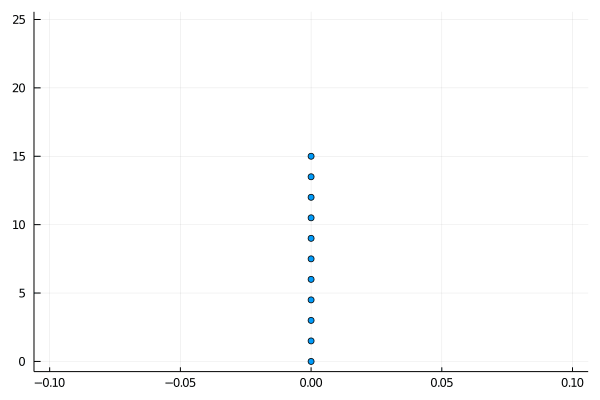

In [6]:
anim = @animate for i ∈ 1:20:(time_steps)
    plot(zeros(num_oscillators+1),values[:IP][:,i], legend=:none, seriestype = :scatter, ylims=[0,maximum(values[:IP])], xlims=[-0.1, 0.1])
end
gif(anim, fps = 15)